## Import libraries

In [2]:
import copy

from vtkmodules.util.numpy_support import vtk_to_numpy

import os, tempfile, nibabel as nib

import abagen
from abagen.images import check_atlas
from abagen import get_expression_data  # abagen>=0.1 uses this module name; if not, try: from abagen import get_expression_data

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from brainspace.utils.parcellation import reduce_by_labels
from brainspace.mesh.mesh_io import write_surface  # BrainSpace I/O
from matplotlib.cm import get_cmap

from brainstat.context.genetics import surface_genetic_expression
from brainstat.datasets import fetch_parcellation
from brainstat.datasets import fetch_template_surface

## Get parcellation and expression

In [9]:
# 1) Labels: single vector (LH||RH) on fsaverage5
labels_vec = fetch_parcellation("fsaverage5", "schaefer",100, join=True).astype(np.int32)

# 2) Surfaces: get BSPolyData from BrainStat and write to GIFTI files (paths!)
lh_bs, rh_bs = fetch_template_surface("fsaverage5", join=False)
tmpdir = tempfile.mkdtemp(prefix="abagen_geom_")
lh_path = os.path.join(tmpdir, "lh.surf.gii")
rh_path = os.path.join(tmpdir, "rh.surf.gii")
write_surface(lh_bs, lh_path)  # (BSPolyData, path) — correct order
write_surface(rh_bs, rh_path)

# 3) Build an abagen AtlasTree using paths + space
atlas = check_atlas(labels_vec, geometry=(lh_path, rh_path), space="fsaverage")

# 4) Fetch gene expression (defaults are usually fine)
#    You can tweak probe selection / normalization later if needed.
expr = get_expression_data(atlas,probe_selection='max_intensity',donor_probes='aggregate')

print(type(expr), getattr(expr, "shape", None))

/home/hanwang/.pyenv/versions/abagen-pyenv/lib/python3.11/site-packages/abagen/probes_.py:181: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  retained = info.groupby('gene_symbol').apply(applyfunc).dropna().squeeze()
/home/hanwang/.pyenv/versions/abagen-pyenv/lib/python3.11/site-packages/abagen/samples_.py:405: FutureWarning: The provided callable <function mean at 0x7d7a02573920> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  microarray.groupby('label').aggregate(metric),
/home/hanwang/.pyenv/versions/abagen-pyenv/lib/python3.11/site-packages/abagen/samples_.py:404: FutureW

<class 'pandas.core.frame.DataFrame'> (100, 15632)


/home/hanwang/.pyenv/versions/abagen-pyenv/lib/python3.11/site-packages/abagen/samples_.py:404: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gene_by_label = pd.concat([
/home/hanwang/.pyenv/versions/abagen-pyenv/lib/python3.11/site-packages/abagen/samples_.py:481: FutureWarning: The provided callable <function mean at 0x7d7a02573920> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  microarray = pd.concat(microarray).groupby('label').aggregate(metric)


## Plot expression against atlas regions

/tmp/ipykernel_3333432/3313671459.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = copy.copy(get_cmap())


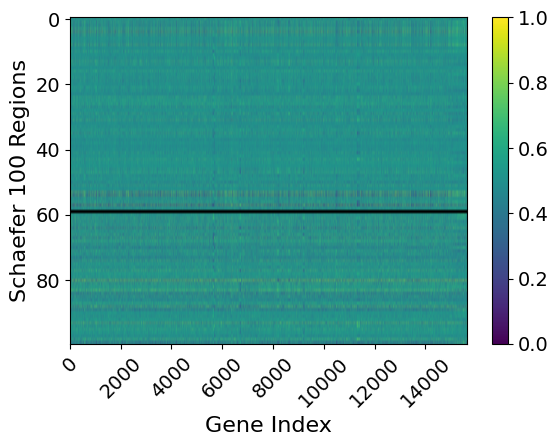

In [10]:
# Plot Schaefer-100 genetic expression matrix.
colormap = copy.copy(get_cmap())
colormap.set_bad(color="black")
plt.imshow(expr, aspect="auto", cmap=colormap)
plt.colorbar().ax.tick_params(labelsize=14)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.xlabel("Gene Index", fontdict={"fontsize": 16})
plt.ylabel("Schaefer 100 Regions", fontdict={"fontsize": 16})
plt.gcf().subplots_adjust(bottom=0.2)

## Plot a single-gene expression on the brain surface

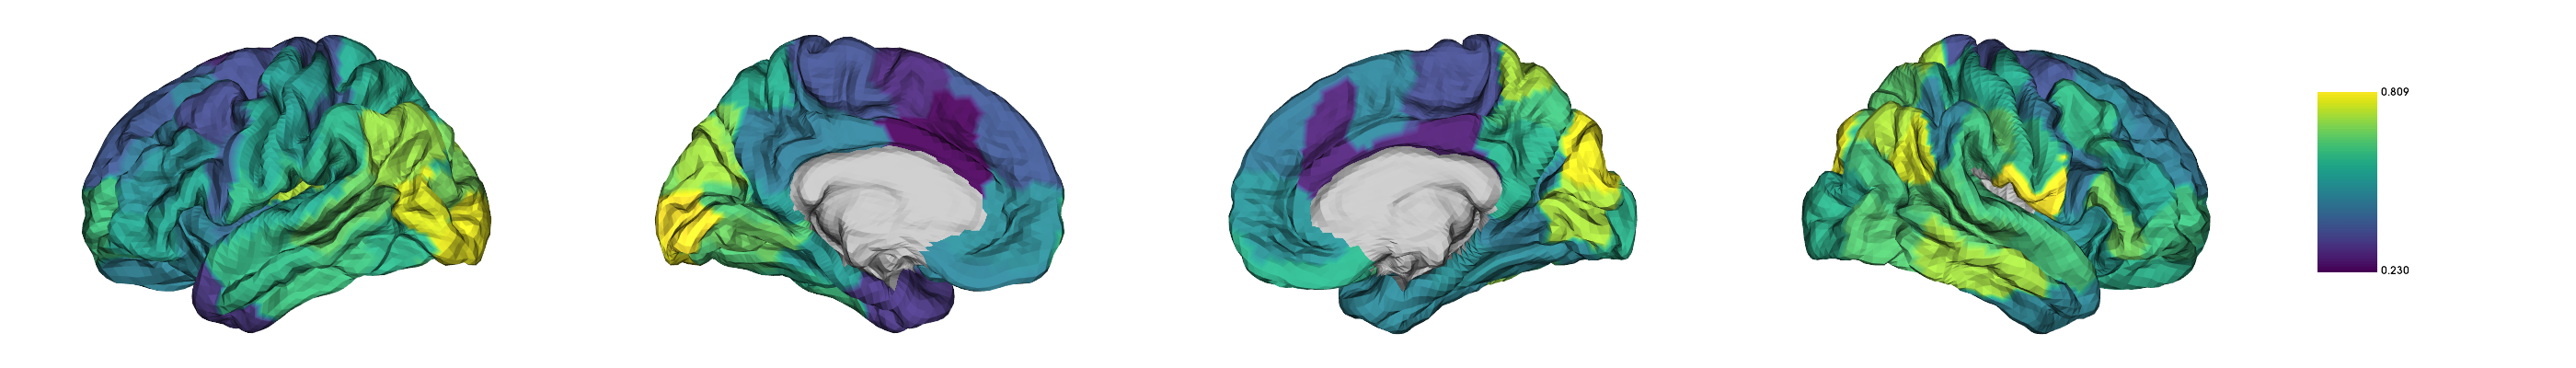

In [11]:
from brainspace.plotting.surface_plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels

single_gene = "FOXP2"

vertexwise_gene = map_to_labels(
    expr[single_gene].to_numpy(),
    labels_vec,
    mask=labels_vec != 0,
    fill=np.nan,
)

plot_hemispheres(
    lh_bs, 
    rh_bs,
    vertexwise_gene,
    color_bar=True,
    embed_nb=True,
    size=(2800, 400),
    zoom=1.45,
    nan_color=(0.7, 0.7, 0.7, 1),
    cb__labelTextProperty={"fontSize": 12},
)